## Image Enhancement By Edge-Preserving Filters

Loading libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_windows
import math

Loading image

In [2]:
im = plt.imread('assets/cameraman.png')
type(im)
im.shape, im.dtype
# The first two indices represent the Y and X position of a pixel,
# and the third represents the RGB colour value of the pixel.

((256, 256), dtype('float32'))

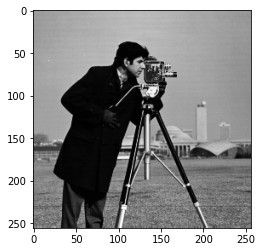

In [3]:
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

$$w_i = e^{-\alpha\|\mathbf x_i-\mathbf x\|_2^2}$$

In [4]:
wi = []


def prefix_wi():
    for i in range(3):
        for j in range(3):
            # if [i, j] != [1, 1]:
            norm = np.linalg.norm(np.array([i, j]) - np.array([1, 1]))
            wi.append(np.exp(-0.5 * norm))


prefix_wi()
print(wi)
sum_wi = sum(wi)
print(sum_wi)

[0.4930686913952398, 0.6065306597126334, 0.4930686913952398, 0.6065306597126334, 1.0, 0.6065306597126334, 0.4930686913952398, 0.6065306597126334, 0.4930686913952398]
5.398397404431493


$$\overline y=\frac{\sum_i y_iw_i}{\sum_i w_i}$$

In [5]:
def overline_y(block):
    multi, count = 0, 0
    for i in range(3):
        for j in range(3):
            multi += block[i][j] * wi[count]
            count += 1
    return multi / sum_wi

$$\beta=(2\sigma_y^2)^{-1}$$

$$\sigma_y^2=\frac{\sum_i(\overline y-y)^{-2}w_i}{\sum_i w_i}$$

In [6]:
def beta(block):
    y = overline_y(block)
    sigma = 0
    count = 0
    for i in range(3):
        for j in range(3):
            sigma += math.pow(overline_y(block[i][j] - block[i][j]), -2) * wi[count]
            count += 1
    sigma /= sum_wi
    return 1 / (2 * sigma)

$$y=\sum_i \frac {y_iw_ie^{-\beta(y_i-y)^2}}{\sum_j w_je^{-\beta(y_j-y)^2}}$$

In [7]:
def output_y(block):
    b = beta(block)
    denominator = 0
    count = 0
    for i in range(3):
        for j in range(3):
            denominator += wi[count] * np.exp(-b * math.pow(block[i][j] - block[1][1]))
            count += 1

    y = 0
    count = 0
    for i in range(3):
        for j in range(3):
            y += (block[i][j] * wi[count] * np.exp(-b * math.pow(block[i][j] - block[1][1]))) / denominator

    return y

In [8]:
def mean(block):
    sigma = []
    for i in block:
        sigma = np.append(sigma, overline_y(i))
    print(sigma)
    return sigma

In [9]:
def variance(block):
    sigma = []
    for i in block:
        sigma = np.append(sigma, output_y(i))
    return sigma

- Expand edge image using opencv

In [10]:
import cv2


def expand(image, b):
    im_expand = cv2.copyMakeBorder(image, b, b, b, b, cv2.BORDER_REPLICATE)
    print(im_expand.shape)
    # plt.imshow(im_expand, cmap=plt.cm.gray, interpolation='nearest')
    # plt.show()
    return im_expand

- Filter a given image $I$ using $\alpha = 1/2$ recursively k times to obtain $I_i$. 

- Compute the local mean $M$ and variance $V$ for every pixel of $I_d$ . The size of the local neighbor-hood is 40 x 40 pixels in all our examples.

$$I_m(\mathbf x)=\begin{cases} {I_i(\mathbf x)} &\text{if } |I_d(\mathbf x)-M(\mathbf x)| < 2.5V(\mathbf x)\\ I(\mathbf x) & \text{otherwise}\end{cases}$$

In [11]:
def enhancement():
    im_expand = expand(im, 1)
    w, h = im_expand.shape

    list_block = view_as_windows(im_expand, (3, 3))
    # print(list_block)

    i_i = np.zeros((h - 2, w - 2))

    for i in range(h - 2):
        for j in range(w - 2):
            i_i[i][j] = output_y(list_block[i][j])

    i_d = np.zeros((h - 2, w - 2))
    i_d = np.reshape(i_d, (h - 2, w - 2))

    # Compute the difference signal I_d = I - I_i.
    for i in range(len(i_d)):
        i_d[i] = im[i] - i_i[i]

    i_m = np.zeros((h - 2, w - 2))

    im_expand_2 = expand(i_d, 20)
    list_block_2 = view_as_windows(im_expand, (40, 40))

    print(im_expand_2.shape)

    for i in range(h - 2):
        for j in range(w - 2):
            mark = list_block_2[i + 20][j + 20]
            if np.abs(i_d[i][j] - mean(mark)) < 2.5 * variance(mark):
                i_m = i_i[i][j]
            else:
                i_m = im[i][j]

    result = np.zeros((h - 2, w - 2))

    # Compute Io = I - sIm; s = 0.5
    for i in range(h - 2):
        for j in range(w - 2):
            result[i][j] = im[i][j] - 0.5 * i_m[i][j]

    # exit - covert array to image
    plt.imshow(result, cmap=plt.cm.gray, interpolation='nearest')
    plt.show()


if __name__ == '__main__':
    enhancement()



(258, 258)


IndexError: invalid index to scalar variable.